## Load and Explore the Dataset

In [21]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('../data/df_file.csv')  

# Map numeric labels to category names
label_to_category = {
    0: 'Politics',
    1: 'Sport',
    2: 'Technology',
    3: 'Entertainment',
    4: 'Business',
    5: 'Other'  
}

# Add a new column for category names
df['category'] = df['Label'].map(label_to_category)

# Display basic info
print("Dataset Overview:")
print(df.head())

print("\nDataset Shape:", df.shape)
print("\nColumn Names and Data Types:")
print(df.dtypes)

# Display class distribution with category names
print("\nClass Distribution:")
print(df['category'].value_counts())

Dataset Overview:
                                                Text  Label  category
0  Budget to set scene for election\n \n Gordon B...      0  Politics
1  Army chiefs in regiments decision\n \n Militar...      0  Politics
2  Howard denies split over ID cards\n \n Michael...      0  Politics
3  Observers to monitor UK election\n \n Minister...      0  Politics
4  Kilroy names election seat target\n \n Ex-chat...      0  Politics

Dataset Shape: (2225, 3)

Column Names and Data Types:
Text        object
Label        int64
category    object
dtype: object

Class Distribution:
category
Sport            511
Business         510
Politics         417
Technology       401
Entertainment    386
Name: count, dtype: int64


### Text Preprocessing

In [22]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char.isalpha() or char == ' '])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing
df['cleaned_text'] = df['Text'].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['Label']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Train-Test Split

In [23]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (1780, 5000)
Testing Data Shape: (445, 5000)


## Train a Classification Model

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
# Use only the labels present in the dataset for evaluation
unique_labels = df['Label'].unique()
label_to_category_eval = {k: v for k, v in label_to_category.items() if k in unique_labels}
print(classification_report(y_test, y_pred, target_names=label_to_category_eval.values()))


# Accuracy
print("\nAccuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

     Politics       0.97      0.96      0.96        92
        Sport       0.99      1.00      0.99        98
   Technology       0.96      0.94      0.95        77
Entertainment       0.96      0.97      0.97        76
     Business       0.94      0.95      0.95       102

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445


Accuracy: 0.9640449438202248


## Confusion Matrix Heatmap

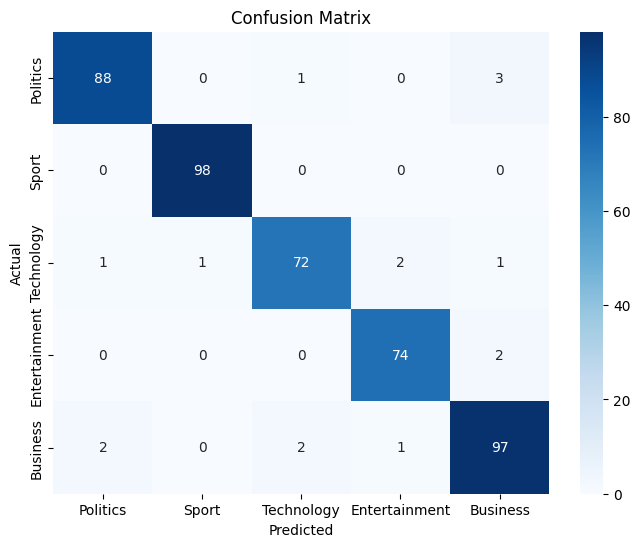

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_category_eval.values(),
            yticklabels=label_to_category_eval.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Word Cloud for Each Category

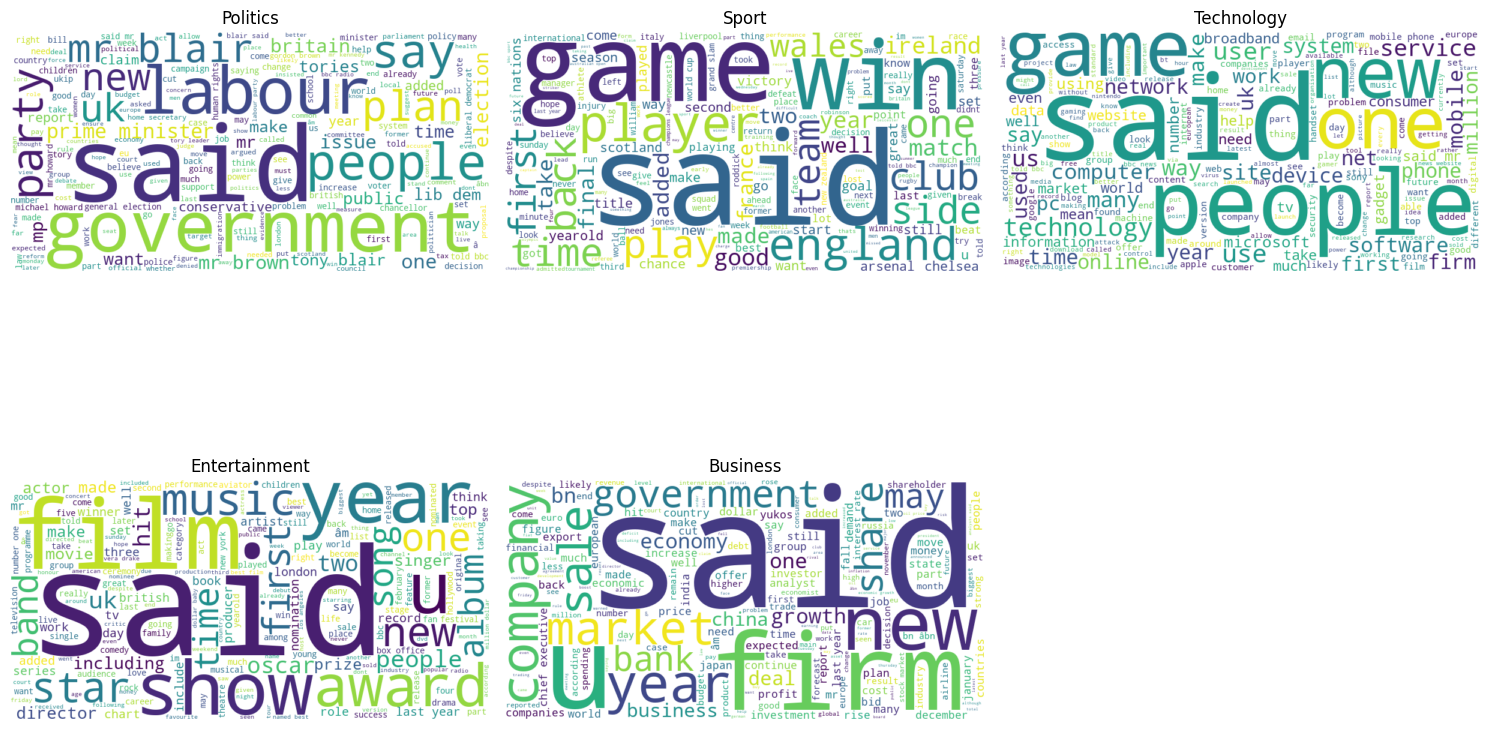

In [26]:
from wordcloud import WordCloud

# Generate word clouds for each category
plt.figure(figsize=(15, 10))
for label, category in label_to_category_eval.items():
    text = ' '.join(df[df['Label'] == label]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(2, 3, label + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Interactive UI for Prediction

In [27]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to predict category with confidence threshold
def predict_category(text, confidence_threshold=0.5):
    cleaned_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([cleaned_text])
    probabilities = model.predict_proba(vectorized_text)[0]
    max_probability = np.max(probabilities)
    
    if max_probability < confidence_threshold:
        return 'Other'
    else:
        predicted_label = model.predict(vectorized_text)[0]
        return label_to_category.get(predicted_label, 'Other')

# Create UI components
input_text = widgets.Textarea(
    placeholder='Enter your document text here...',
    description='Text:',
    layout=widgets.Layout(width='500px', height='150px'))
predict_button = widgets.Button(description="Predict")
output = widgets.Output()

# Function to handle button click
def on_predict_button_clicked(b):
    with output:
        clear_output()
        text = input_text.value.strip()
        if text:
            category = predict_category(text)
            print(f"Predicted Category: {category}")
        else:
            print("Please enter some text.")

# Attach function to button
predict_button.on_click(on_predict_button_clicked)

# Display UI
display(widgets.VBox([input_text, predict_button, output]))

In [28]:
import os
import joblib

models_folder = '../models'

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

model_path = os.path.join(models_folder, 'document_classifier.pkl')
vectorizer_path = os.path.join(models_folder, 'tfidf_vectorizer.pkl')

joblib.dump(model, model_path)
joblib.dump(vectorizer, vectorizer_path)

print(f"Model saved to: {model_path}")
print(f"Vectorizer saved to: {vectorizer_path}")

Model saved to: ../models\document_classifier.pkl
Vectorizer saved to: ../models\tfidf_vectorizer.pkl
